In [45]:
# Add the path to import module
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import feature_eng.utils as utils
import feature_eng.data_clean as data_clean
import feature_eng.feature_eng as feature_eng
import evaluator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor

%matplotlib inline

In [2]:
train, prop = utils.load_train_data('../data/')

/home/hzn/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2821: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [46]:
df = train.merge(prop, how='left', on='parcelid')

In [47]:
df = feature_eng.add_missing_column_boolean(df)

In [48]:
train_df, test_df = utils.split_by_date(df)

In [49]:
train_df = data_clean.drop_training_only_column(train_df)
test_df = data_clean.drop_training_only_column(test_df)

In [50]:
data_clean.cat2num(train_df)
data_clean.cat2num(test_df)

In [51]:
X_train, y_train = utils.get_features_target(train_df)
X_test, y_test = utils.get_features_target(test_df)

In [26]:
ev = evaluator.Evaluator()
ev.load_train_test((X_train, y_train, X_test, y_test))

In [14]:
lgb = LGBMRegressor(**{
       "seed": 42, "nthread": 4, "silent": True, "boosting_type": "gbdt",
       "objective": "regression_l2", "colsample_bytree": 0.7,
       "learning_rate": 0.03, "max_bin": 30, "min_child_samples": 500,
       "n_estimators": 30, "reg_lambda": 1, "subsample": 0.7,
       "subsample_freq": 30
     })

In [27]:
ev.fit(predictor=lgb, error_output=0)

Using model:  
Fitting from training data
Predicting
Results:

Training set 0.06804221860468193
Testing set 0.06523634837417262
params None


In [28]:
from sklearn.ensemble import RandomForestClassifier

In [63]:
y_train_classifier = abs(y_train) > 0.1

In [62]:
y_test_classifier = abs(y_test) > 0.1

In [31]:
rfc = RandomForestClassifier(** {
       "random_state": 42,
       "n_estimators": 100,
       "max_features": "sqrt",
       "min_samples_leaf": 1000,
       "max_depth": 10
     })

In [54]:
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

In [64]:
rfc.fit(X_train, y_train_classifier)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1000,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [65]:
y_score = rfc.predict_proba(X_test)

In [60]:
rfc.classes_

array([False,  True], dtype=bool)

In [42]:
y_score[:,1].shape

(8542,)

In [61]:
X_test.shape

(8542, 117)

In [37]:
from sklearn.metrics import precision_recall_curve

In [66]:
pr_curve = precision_recall_curve(y_test_classifier, y_score[:,1])

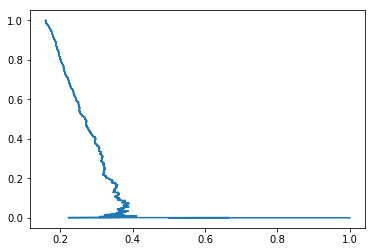

In [67]:
plt.plot(pr_curve[0], pr_curve[1])
plt.show()